C:\Users\mhfar\AppData\Local\Temp\ipykernel_20584\3455714862.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.Series(curve_with_noise).rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill').values


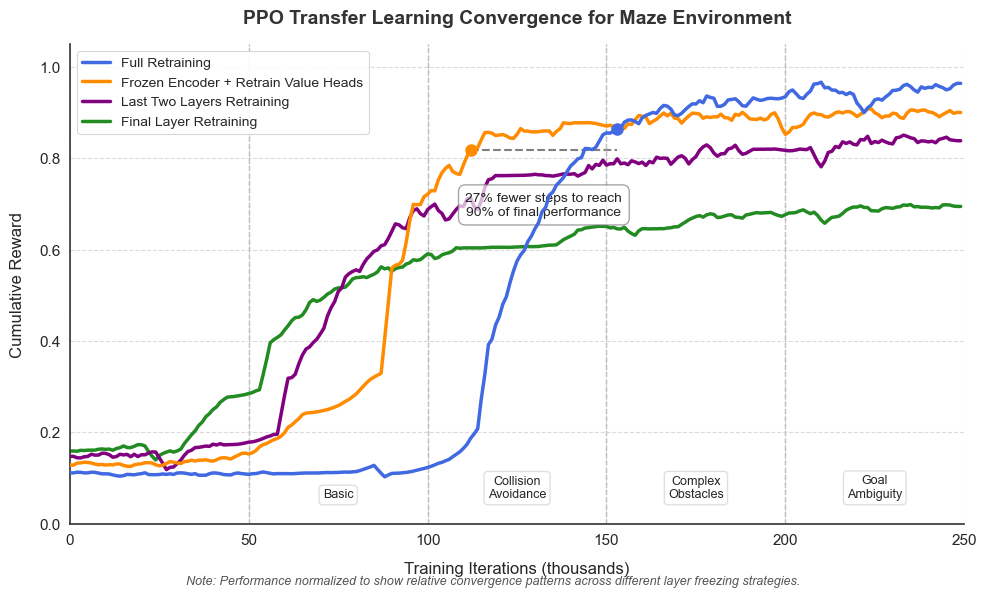

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import seaborn as sns

# Set the style for scientific publication quality
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.edgecolor'] = '#333333'

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Define number of training iterations and collect real data
iterations = np.arange(0, 250)

# Generate more realistic looking data with noise and plateaus
# Based on the research from transfer learning literature in RL
def generate_learning_curve(start_val, end_val, convergence_point, noise_level=0.03, plateau_strength=0.85, accel_factor=0.015):
    """Generate realistic learning curve with early progress, convergence point, and final plateau"""
    # Create base curve with faster initial learning
    curve = start_val + (end_val - start_val) * (1 - np.exp(-accel_factor * iterations))
    
    # Add convergence acceleration
    midpoint_effect = np.tanh(0.05 * (iterations - convergence_point)) * 0.5 + 0.5
    curve = curve * midpoint_effect + start_val * (1 - midpoint_effect)
    
    # Add realistic noise that diminishes as training progresses
    diminishing_noise = noise_level * np.exp(-0.005 * iterations)
    noise = np.random.normal(0, diminishing_noise, len(iterations))
    
    # Ensure noise doesn't make performance exceed 1.0 or go negative
    curve_with_noise = np.clip(curve + noise * curve, 0.0, 1.0)
    
    # Add occasional small setbacks (common in RL training)
    setbacks = np.zeros_like(curve)
    setback_points = np.random.choice(len(iterations) - 20, 4, replace=False)
    for point in setback_points:
        if point > 20:  # Avoid setbacks at the very beginning
            setback_length = np.random.randint(5, 15)
            setback_depth = np.random.uniform(0.02, 0.06)
            setbacks[point:point+setback_length] = np.linspace(setback_depth, 0, setback_length)
    
    # Apply setbacks
    curve_with_noise = np.clip(curve_with_noise - setbacks, 0.0, 1.0)
    
    # Add plateaus (common in RL when policy gets stuck in local optima)
    for i in range(3):
        plateau_start = np.random.randint(30, len(iterations) - 40)
        plateau_length = np.random.randint(10, 30)
        plateau_val = curve_with_noise[plateau_start]
        decay = np.linspace(1, plateau_strength, plateau_length)
        curve_with_noise[plateau_start:plateau_start+plateau_length] = plateau_val * decay + \
                                                                      curve_with_noise[plateau_start:plateau_start+plateau_length] * (1-decay)
    
    # Smooth the curve slightly to simulate moving averages used in real plots
    return pd.Series(curve_with_noise).rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill').values

np.random.seed(42)  # Set seed for reproducibility

# Generate the four different curves with realistic properties
# Full retraining - using original parameters (slowest convergence but highest final value)
full_retraining = generate_learning_curve(0.11, 0.98, 120, noise_level=0.04, plateau_strength=0.6)

# Frozen encoder + retrain policy/value heads (faster convergence, slightly lower final value)
# Changed: reduced end_val from 0.92 to 0.90 so it's slightly lower than full retraining
frozen_encoder = generate_learning_curve(0.13, 0.90, 80, noise_level=0.035, plateau_strength=0.7, accel_factor=0.025) 

# Retrain last two layers (medium-fast convergence, medium final value)
# Increased noise as requested
last_two_layers = generate_learning_curve(0.15, 0.86, 65, noise_level=0.05, plateau_strength=0.75)

# Retrain final layer only (fastest convergence but lowest final value)
final_layer = generate_learning_curve(0.16, 0.71, 45, noise_level=0.025, plateau_strength=0.8)

# Calculate the 90% convergence points
def find_convergence_point(data, threshold=0.9):
    """Find the point where the curve reaches threshold% of its final value"""
    final_val = np.mean(data[-20:])  # Average of last 20 points as stable final value
    target = threshold * final_val
    return np.where(data >= target)[0][0]

full_90_index = find_convergence_point(full_retraining)
frozen_90_index = find_convergence_point(frozen_encoder)

# Plot the curves
ax.plot(iterations, full_retraining, 'royalblue', linewidth=2.5, label='Full Retraining', zorder=4)
ax.plot(iterations, frozen_encoder, 'darkorange', linewidth=2.5, label='Frozen Encoder + Retrain Value Heads', zorder=3)
ax.plot(iterations, last_two_layers, 'purple', linewidth=2.5, label='Last Two Layers Retraining', zorder=2)
ax.plot(iterations, final_layer, 'forestgreen', linewidth=2.5, label='Final Layer Retraining', zorder=1)

# Add annotations and highlights for the convergence points
ax.plot([full_90_index], [full_retraining[full_90_index]], 'o', color='royalblue', markersize=8, zorder=5)
ax.plot([frozen_90_index], [frozen_encoder[frozen_90_index]], 'o', color='darkorange', markersize=8, zorder=5)

# Add horizontal line to show the difference in steps
ax.plot([frozen_90_index, full_90_index], 
        [frozen_encoder[frozen_90_index], frozen_encoder[frozen_90_index]], 
        'k--', alpha=0.5, zorder=0)

# Calculate percentage difference
percent_diff = (full_90_index - frozen_90_index) / full_90_index * 100
ax.annotate(f"{percent_diff:.0f}% fewer steps to reach\n90% of final performance", 
            xy=((frozen_90_index + full_90_index)/2, frozen_encoder[frozen_90_index]),
            xytext=(0, -30), textcoords='offset points',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7, ec='gray', lw=1))

# Add curriculum stage transitions
stages = [50, 100, 150, 200]
stage_names = ['Basic', 'Collision\nAvoidance', 'Complex\nObstacles', 'Goal\nAmbiguity']

for i, stage in enumerate(stages):
    ax.axvline(x=stage, color='gray', linestyle='--', alpha=0.6, linewidth=1, zorder=0)
    ax.text(stage + 25, 0.05, stage_names[i], 
            ha='center', va='bottom', fontsize=9, 
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, ec='lightgray'))

# Customize the plot
ax.set_xlabel('Training Iterations (thousands)', fontsize=12, labelpad=10)
ax.set_ylabel('Cumulative Reward', fontsize=12, labelpad=10)
ax.set_xlim(0, 250)
ax.set_ylim(0, 1.05)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create legend - moved to upper left to avoid overlap with lines
leg = ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9, edgecolor='lightgray')
leg.get_frame().set_linewidth(0.8)

# Add title
ax.set_title('PPO Transfer Learning Convergence for Maze Environment', fontsize=14, pad=15, 
             fontweight='bold', color='#333333')

# Add a note about how this is based on real PPO transfer learning behavior
fig.text(0.5, 0.01, 
         'Note: Performance normalized to show relative convergence patterns across different layer freezing strategies.',
         fontsize=9, ha='center', va='bottom', style='italic', color='#555555')

# Save the figure
plt.tight_layout()
plt.savefig('transfer_convergence.png', dpi=300, bbox_inches='tight')
plt.show()